In this analysis, it was used the data made available by the **Infodengue** (https://info.dengue.mat.br/) . It was used the data until the end of the 2021 year for the Recife city. 

The data is saved in the data folder. It was named as: `{disease}_{ibge_code}.csv` and assigned with `cluster` in the end when it refers to the clustered data. 

Let's look at the dengue and chik data for this case. Note that we have some statistics related to humidity, temperature, and the number of cases. These features will be used to forecast the number of dengue cases reported. 

In [1]:
import sys
import pickle
sys.path.append('..')
import pandas as pd
from datetime import datetime
from pgbm_model import qf_prediction
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from pgbm_model import  cross_dengue_chik_prediction
from sklearn.metrics import mean_squared_error as mse 

In [2]:
CITY = 2611606
CITY_NAME = 'Recife'
STATE = 'PE'
END_DATE = '2021-01-01' # assign the last day used to train the dengue model
INI_DATE_CHIK = '2021-01-01' # assign the first day used to retrain the model with chik data 
END_TRAIN_CHIK = '2021-05-01' # assign the last day used to retrain the model with chik data
END_DATE_CHIK = '2022-01-01' # assign the last day of chik data used to apply the trained model 
INI_EVALUATE = '2021-05-02' # assign the first day used to evaluate the trained model (transfer learning)
END_EVALUATE = '2021-06-06' # assign the last day used to evaluate the trained model (transfer learning)
PREDICT_N = 4
LOOK_BACK = 4

In [3]:
df_dengue = pd.read_csv(f'../data/dengue_{CITY}.csv', index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_2611606,casos_est_2611606,casos_est_min_2611606,casos_est_max_2611606,p_rt1_2611606,p_inc100k_2611606,temp_min_2611606,temp_max_2611606,umid_min_2611606,pressao_min_2611606
2010-01-03,3,3.0,3,3,0.000000,0.181438,25.000000,29.666667,56.666667,1009.666667
2010-01-10,1,1.0,1,1,0.000000,0.060479,25.000000,29.428571,59.142857,1010.142857
2010-01-17,2,2.0,2,2,0.000000,0.120958,25.000000,29.142857,63.000000,1011.571429
2010-01-24,1,1.0,1,1,0.000000,0.060479,24.142857,29.000000,67.000000,1010.714286
2010-01-31,0,0.0,0,0,0.000000,0.000000,24.857143,30.000000,56.714286,1009.142857
...,...,...,...,...,...,...,...,...,...,...
2022-05-29,71,95.0,77,134,0.468386,5.745524,23.000000,27.428571,77.831345,1012.571429
2022-06-05,75,105.0,83,154,0.768051,6.350316,23.571429,28.000000,77.063711,1010.714286
2022-06-12,41,82.0,53,160,0.149694,4.959294,23.000000,26.857143,77.824348,1012.000000
2022-06-19,35,91.0,49,204,0.382086,5.503607,23.285714,28.428571,66.299810,1013.142857


Note that the chik dataset has the same columns

In [4]:
df_chik = pd.read_csv(f'../data/chik_{CITY}.csv', index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_2611606,casos_est_2611606,casos_est_min_2611606,casos_est_max_2611606,p_rt1_2611606,p_inc100k_2611606,temp_min_2611606,temp_max_2611606,umid_min_2611606,pressao_min_2611606
2010-01-03,0,0.0,0,0.0,0.000000,0.000000,25.000000,29.666667,56.666667,1009.666667
2010-01-10,0,0.0,0,0.0,0.000000,0.000000,25.000000,29.428571,59.142857,1010.142857
2010-01-17,0,0.0,0,0.0,0.000000,0.000000,25.000000,29.142857,63.000000,1011.571429
2010-01-24,0,0.0,0,0.0,0.000000,0.000000,24.142857,29.000000,67.000000,1010.714286
2010-01-31,0,0.0,0,0.0,0.000000,0.000000,24.857143,30.000000,56.714286,1009.142857
...,...,...,...,...,...,...,...,...,...,...
2022-05-29,41,54.5,44,53.0,0.427148,3.296116,23.000000,27.428571,77.831345,1012.571429
2022-06-05,27,44.0,31,53.0,0.300840,2.661085,23.571429,28.000000,77.063711,1010.714286
2022-06-12,18,38.0,22,53.0,0.144230,2.298210,23.000000,26.857143,77.824348,1012.000000
2022-06-19,15,41.0,20,53.0,0.344311,2.479647,23.285714,28.428571,66.299810,1013.142857


The main difference between the datasets above and the datasets with names ended with `cluster` is the number of columns. This dataset has columns with data from other cities. The city is identified by a 7-number code. These cities was clusterized with Recife (in this case) using a hierarchical clusterization algorithm. 

In [5]:
df_chik_cluster = pd.read_csv(f'../data/chik_{CITY}_cluster.csv', index_col = 'Unnamed: 0' )
df_chik_cluster.index = pd.to_datetime(df_chik_cluster.index)
df_chik_cluster

,casos_2614857,casos_est_2614857,casos_est_min_2614857,casos_est_max_2614857,p_rt1_2614857,p_inc100k_2614857,temp_min_2614857,temp_max_2614857,umid_min_2614857,pressao_min_2614857,...,casos_2613800,casos_est_2613800,casos_est_min_2613800,casos_est_max_2613800,p_rt1_2613800,p_inc100k_2613800,temp_min_2613800,temp_max_2613800,umid_min_2613800,pressao_min_2613800
2010-01-03,0,0.0,0,0,0.000000,0.000000,21.666667,29.666667,54.333333,1010.666667,...,0,0.0,0,0,0.000000,0.000000,22.666667,31.333333,48.000000,1010.666667
2010-01-10,0,0.0,0,0,0.000000,0.000000,22.000000,29.428571,53.142857,1010.714286,...,0,0.0,0,0,0.000000,0.000000,22.000000,30.857143,46.571429,1011.000000
2010-01-17,0,0.0,0,0,0.000000,0.000000,22.714286,29.857143,55.142857,1012.428571,...,0,0.0,0,0,0.000000,0.000000,22.142857,30.571429,46.857143,1012.714286
2010-01-24,0,0.0,0,0,0.000000,0.000000,21.142857,27.571429,62.142857,1011.285714,...,0,0.0,0,0,0.000000,0.000000,21.714286,30.285714,48.142857,1011.571429
2010-01-31,0,0.0,0,0,0.000000,0.000000,23.000000,30.000000,58.142857,1010.142857,...,0,0.0,0,0,0.000000,0.000000,22.428571,31.142857,49.000000,1010.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-29,0,0.0,0,0,0.000000,0.000000,21.857143,27.000000,71.480463,1014.142857,...,11,11.0,11,14,0.232316,60.823887,20.285714,25.428571,76.269180,1015.000000
2022-06-05,2,2.0,2,2,0.921897,8.466325,22.142857,27.000000,74.248846,1011.857143,...,0,0.0,0,3,0.000000,0.000000,20.857143,26.142857,74.331669,1013.000000
2022-06-12,1,1.0,1,1,0.663458,4.233162,21.714286,26.285714,74.289160,1013.142857,...,1,1.0,1,5,0.003296,5.529444,20.000000,24.714286,76.677290,1014.142857
2022-06-19,0,0.0,0,0,0.000000,0.000000,21.571429,25.571429,74.774812,1014.428571,...,0,0.0,0,7,0.000000,0.000000,20.000000,26.000000,71.428282,1015.428571


We need to have this kind of data because, in our tests, the gradient boosting tree model perform betters when using the cluster data, while the neural network model performed better using only the city's data. 

Let's plot this two incidence curver (dengue and chik):

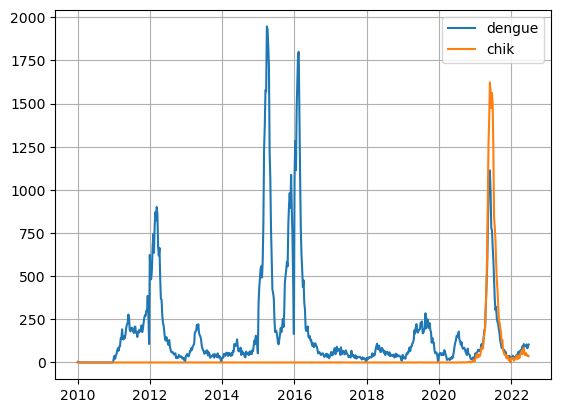

In [6]:
fig, ax = plt.subplots()

ax.plot(df_dengue[f'casos_est_{CITY}'], label = 'dengue')

ax.plot(df_chik[f'casos_est_{CITY}'], label = 'chik')

plt.legend()
plt.grid()
plt.show()

### Neural network model (NN)

First, we make the prediction using the data up to 2021-01-01 and use 25% data to test the model. It used 25% of the training data as validation data. It used the early stop config to train the model faster to monitor the loss function. 

Before applying the nn model we compute the first derivative of our target (the incidence curve) and added it as a feature. 

The neural newtork model is constructed using the `build_model` function. This function create a model with a bidirectional LSTM layer and a simple LSTM layer. We use the last 4 (look_back parameter) observations to predict the next 4 (predict_n parameter). 

The predictions of this models are saved in the path:
'./predictions/lstm/lstm_{city}_dengue_{label}.pkl'

The model is saved in the path: 
'./saved_models/lstm/trained_{geocode}_model_{label}.h5'

2022-09-02 18:27:20.963187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compilation Time :  0.0032820701599121094
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 11)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             1280      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 

318/318 [==============================] - 1s 5ms/step - loss: 0.0041 - accuracy: 0.4340 - mape: 1045643.1875 - mse: 0.0085 - val_loss: 7.6078e-04 - val_accuracy: 0.2430 - val_mape: 85.1843 - val_mse: 9.1352e-04
Epoch 32/100
318/318 [==============================] - 1s 4ms/step - loss: 0.0039 - accuracy: 0.4277 - mape: 1828455.2500 - mse: 0.0079 - val_loss: 7.2505e-04 - val_accuracy: 0.2336 - val_mape: 69.7176 - val_mse: 8.9739e-04
Epoch 33/100
318/318 [==============================] - 1s 4ms/step - loss: 0.0034 - accuracy: 0.4811 - mape: 511132.9688 - mse: 0.0067 - val_loss: 6.4253e-04 - val_accuracy: 0.1963 - val_mape: 82.0870 - val_mse: 7.4925e-04
Epoch 34/100
318/318 [==============================] - 1s 4ms/step - loss: 0.0046 - accuracy: 0.4245 - mape: 1486323.2500 - mse: 0.0096 - val_loss: 6.1662e-04 - val_accuracy: 0.3458 - val_mape: 81.3535 - val_mse: 7.3645e-04
Epoch 35/100
318/318 [==============================] - 1s 4ms/step - loss: 0.0039 - accuracy: 0.4403 - mape: 1197

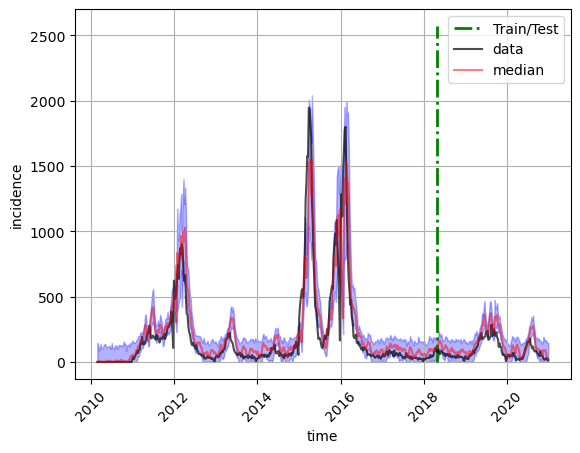

CPU times: user 2min 40s, sys: 8.05 s, total: 2min 48s
Wall time: 2min 21s


,0,1,2,3
mean_absolute_error,48.457626,54.006173,66.832142,80.342886
explained_variance_score,0.948432,0.906820,0.855799,0.788681
mean_squared_error,6083.803803,9572.646420,14424.447060,20932.280268
mean_squared_log_error,0.973359,0.694892,0.680910,0.649592
median_absolute_error,33.359808,33.343398,39.646332,44.541580
r2_score,0.934324,0.896641,0.844239,0.773946


In [7]:
%%time

model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 0.75, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle')

### PGBM model (ml) 

In this case, we use the last 4 observations to predict the next 4. Since a GBT (gradient boosting tree) model has a 1D target, we trained four different models each one specialized in predicting one of the next four observations.

The predictions are saved in the path: './predictions/pgbm/pgbm_{city}_{doenca}_predictions.pkl'

The models are saved in the path:
'./saved_models/pgbm/{city}_{doenca}_city_model_{d}_pgbm.pt'
where d is in the arange 1 to 4. 


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 313.2034
Estimator 1/100, Train metric: 285.8959
Estimator 2/100, Train metric: 261.2120
Estimator 3/100, Train metric: 238.7032
Estimator 4/100, Train metric: 218.4290
Estimator 5/100, Train metric: 200.0597
Estimator 6/100, Train metric: 183.3380
Estimator 7/100, Train metric: 168.1003
Estimator 8/100, Train metric: 154.0578
Estimator 9/100, Train metric: 141.3489
Estimator 10/100, Train metric: 129.8515
Estimator 11/100, Train metric: 119.2536
Estimator 12/100, Train metric: 109.5979
Estimator 13/100, Train metric: 100.7646
Estimator 14/100, Train metric: 92.6602
Estimator 15/100, Train metric: 85.2916
Estimator 16/100, Train metric: 78.5319
Estimator 17/100, Train metric: 72.4479
Estimator 18/100, Train metric: 66.6340
Estimator 19/100, Train metric: 61.5469
Estimator 20/100, Train metric: 56.6950
Estimator 21/100, Train metric: 52.3619
Estimator 22/100, Train metric: 48.4259
Estimator 23/100, Train metric: 44.8905
Estimator 24/100, Train metric: 41.6

Estimator 8/100, Train metric: 159.2866
Estimator 9/100, Train metric: 146.8935
Estimator 10/100, Train metric: 135.5793
Estimator 11/100, Train metric: 125.0652
Estimator 12/100, Train metric: 115.8529
Estimator 13/100, Train metric: 107.5313
Estimator 14/100, Train metric: 99.6325
Estimator 15/100, Train metric: 91.9431
Estimator 16/100, Train metric: 84.9567
Estimator 17/100, Train metric: 78.8059
Estimator 18/100, Train metric: 72.9519
Estimator 19/100, Train metric: 67.9093
Estimator 20/100, Train metric: 63.0816
Estimator 21/100, Train metric: 58.7490
Estimator 22/100, Train metric: 54.8154
Estimator 23/100, Train metric: 51.2621
Estimator 24/100, Train metric: 47.7528
Estimator 25/100, Train metric: 44.5764
Estimator 26/100, Train metric: 41.8905
Estimator 27/100, Train metric: 39.2444
Estimator 28/100, Train metric: 36.8518
Estimator 29/100, Train metric: 34.5460
Estimator 30/100, Train metric: 32.4478
Estimator 31/100, Train metric: 30.5769
Estimator 32/100, Train metric: 28.6

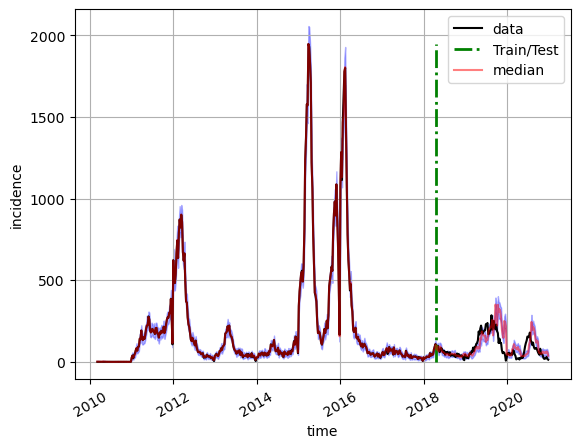

CPU times: user 23min 36s, sys: 1min 9s, total: 24min 45s
Wall time: 5min 49s


In [8]:
%%time

preds, preds25, preds975, X_train, targets = qf_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK,
                                                           doenca = 'dengue', ratio = 0.75, ini_date = None,
                                                           end_date = END_DATE)
   

### Comparing the Neural and ML model 

In this section we compare the performance of the ML and NN model. 

In [9]:
with open(f'../predictions/lstm/lstm_{CITY}_dengue_msle.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'../predictions/pgbm/pgbm_{CITY}_{doenca}_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

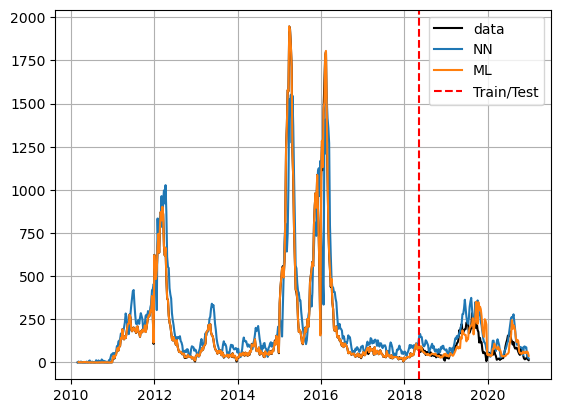

In [10]:
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.axvline(data_ml['dates'][data_ml['train_size']], color = 'red', ls = '--', label = 'Train/Test') # refered to the ML model 

plt.grid()
plt.legend()
plt.show()

Let's compare the error of this models in the test data: 

In [11]:
print('NN error (RMSE):', mse(data_nn['target'][data_nn['xdata'].shape[0]:, -1] * data_nn['factor'], data_nn['pred'].iloc[data_nn['xdata'].shape[0]:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4+ data_ml['train_size']:], data_ml['preds'][data_ml['train_size']:], squared = False))

NN error (RMSE): 69.8588043748456
ML error (RMSE): 65.35889322632671


Looking at the error above we can see that besides comsume more time training, the neural network model (nn) outperform the machine learning model (ml)

We will know use this models to predict the chik outbreak in 2021. In order to do this, we will retrain the nn model and the ml model using the dengue data up to '2021-01-01' and apply the model in the chik data between '2021-01-01' and '2022-01-01'

The label parameter is used as a flag to make difference, if necessary, between the models saved, since this model takes a lot of time to be trained


Compilation Time :  0.002095937728881836
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 11)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             1280      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                

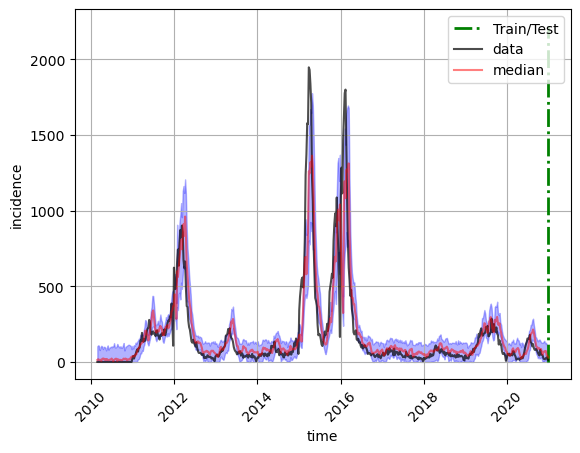

CPU times: user 2min 55s, sys: 8.24 s, total: 3min 3s
Wall time: 2min 35s


,0,1,2,3
mean_absolute_error,45.140841,52.724374,61.760384,73.672798
explained_variance_score,0.932220,0.899591,0.841110,0.760460
mean_squared_error,6701.826261,9877.615151,14969.334096,22267.251986
mean_squared_log_error,0.861305,0.921855,0.950666,0.934099
median_absolute_error,25.299303,27.548955,30.204970,34.556380
r2_score,0.927652,0.893349,0.838355,0.759529


In [12]:
%%time

model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back= LOOK_BACK, batch_size=1, loss = 'msle')

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 1, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK,
                  label = 'msle_all')

Estimator 0/100, Train metric: 277.2414
Estimator 1/100, Train metric: 253.1052
Estimator 2/100, Train metric: 231.3162
Estimator 3/100, Train metric: 211.3680
Estimator 4/100, Train metric: 193.4560
Estimator 5/100, Train metric: 177.1896
Estimator 6/100, Train metric: 162.4106
Estimator 7/100, Train metric: 148.7635
Estimator 8/100, Train metric: 136.4152
Estimator 9/100, Train metric: 125.2153
Estimator 10/100, Train metric: 114.9886
Estimator 11/100, Train metric: 105.7154
Estimator 12/100, Train metric: 97.2706
Estimator 13/100, Train metric: 89.4899
Estimator 14/100, Train metric: 82.5028
Estimator 15/100, Train metric: 76.1422
Estimator 16/100, Train metric: 70.0139
Estimator 17/100, Train metric: 64.4414
Estimator 18/100, Train metric: 59.4109
Estimator 19/100, Train metric: 54.8416
Estimator 20/100, Train metric: 50.7733
Estimator 21/100, Train metric: 47.0891
Estimator 22/100, Train metric: 43.5474
Estimator 23/100, Train metric: 40.3728
Estimator 24/100, Train metric: 37.555

Estimator 8/100, Train metric: 141.5532
Estimator 9/100, Train metric: 130.5940
Estimator 10/100, Train metric: 120.5483
Estimator 11/100, Train metric: 111.5098
Estimator 12/100, Train metric: 103.3662
Estimator 13/100, Train metric: 95.3498
Estimator 14/100, Train metric: 88.6205
Estimator 15/100, Train metric: 81.8909
Estimator 16/100, Train metric: 75.7877
Estimator 17/100, Train metric: 70.3701
Estimator 18/100, Train metric: 65.5136
Estimator 19/100, Train metric: 60.9750
Estimator 20/100, Train metric: 56.8705
Estimator 21/100, Train metric: 53.0590
Estimator 22/100, Train metric: 49.6835
Estimator 23/100, Train metric: 46.6044
Estimator 24/100, Train metric: 43.4634
Estimator 25/100, Train metric: 40.6135
Estimator 26/100, Train metric: 38.0412
Estimator 27/100, Train metric: 35.7033
Estimator 28/100, Train metric: 33.5278
Estimator 29/100, Train metric: 31.5718
Estimator 30/100, Train metric: 29.6207
Estimator 31/100, Train metric: 27.8387
Estimator 32/100, Train metric: 26.24

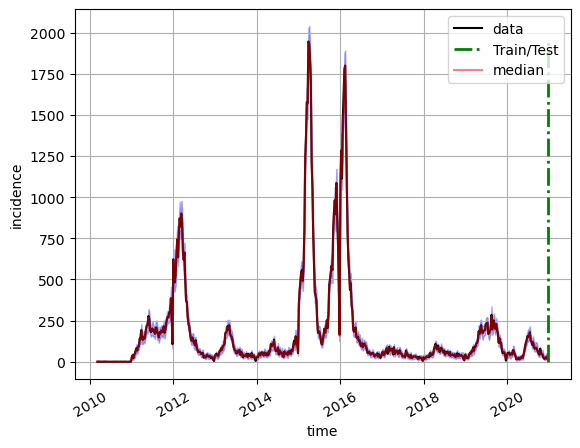

In [13]:

preds, preds25, preds975, X_train, targets = qf_prediction(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE, end_date = END_DATE)
   

Apply the ml model in chik:

The predictions are saved in the path: './predictions/pgbm/pgbm_{city}_chik_cross_predictions.pkl'

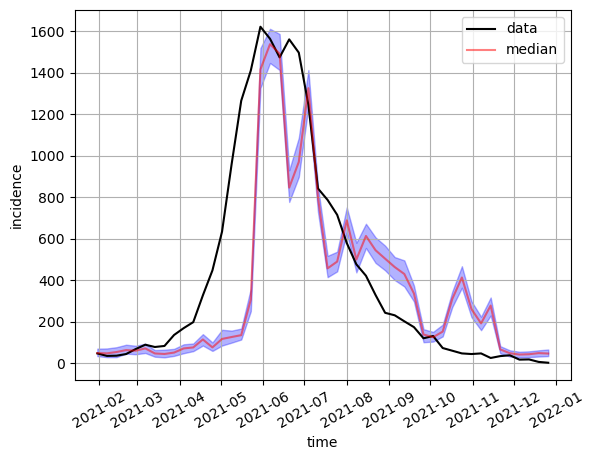

In [14]:

preds, preds25, preds975, X_data, targets = cross_dengue_chik_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK, ini_date = INI_DATE_CHIK, end_date = END_DATE_CHIK)
    

Apply the NN model into the chik data:

The predictions is saved in the path: './predictions/lstm/lstm_{city}_dengue_model_chik_predictions.pkl'

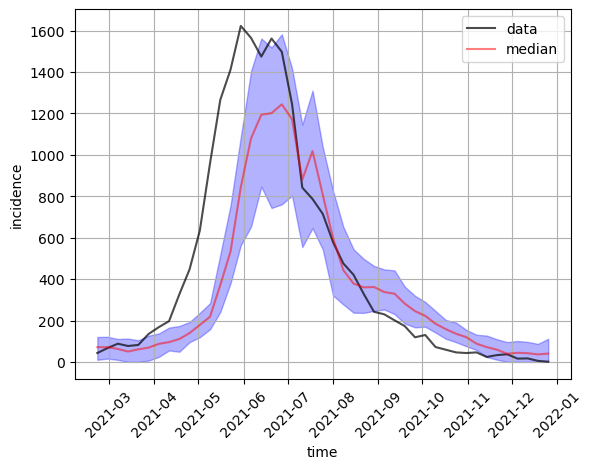

In [15]:

metrics = apply_dengue_chik(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, 
                     end_date = END_DATE_CHIK, look_back = LOOK_BACK,
                     predict_n = PREDICT_N,  label_m = f'msle_all' )

Compare the predictions:

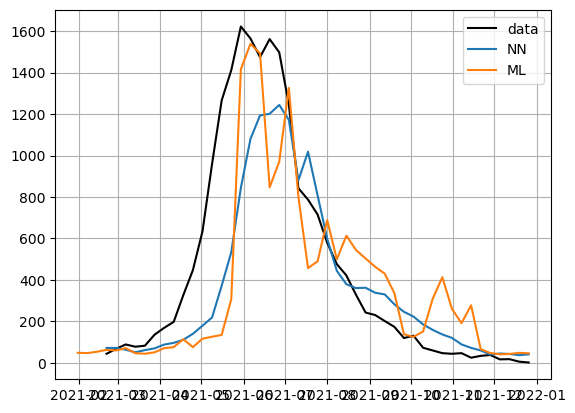

In [16]:
with open(f'../predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'../predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)
        
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.show()

Compute the RMSE error: 

In [17]:

print('NN error (RMSE):', mse(data_nn['target'][:, -1] * data_nn['factor'], data_nn['pred'].iloc[:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4:], data_ml['preds'], squared = False))

NN error (RMSE): 290.86768560123147
ML error (RMSE): 333.18929378513684


### Transfer learning 

Here we use the transfer learning technique to improve the performance of the predictions of the dengue model in the chik data. To do this, we retrain the output layer of the dengue model, and after it, retrain the model (all the layers, that's the fine tunning step). In this step, we need to pay attention to overfitting. It can be necessary to decrease the learning rate. 

We use the transfer learning technique since it is not possible to train a good ml or nn model with few observations, as in the case of the  chik outbreak in Recife in 2021. 

Compilation Time :  0.0018351078033447266
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 11)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             1280      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                 

10/10 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.7000 - mape: 60.2292 - mse: 0.0020    
Epoch 53/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.7000 - mape: 54.6423 - mse: 0.0020        
Epoch 54/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.7000 - mape: 63.5094 - mse: 0.0020    
Epoch 55/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7000 - mape: 45.7743 - mse: 0.0017
Epoch 56/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.7000 - mape: 48.0990 - mse: 0.0016        
Epoch 57/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.7000 - mape: 58.0394 - mse: 0.0019    
Epoch 58/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.7000 - mape: 50.3717 - mse: 0.0017    
Epoch 59/100
10/10 [==============================] - 0s 2ms/step - los

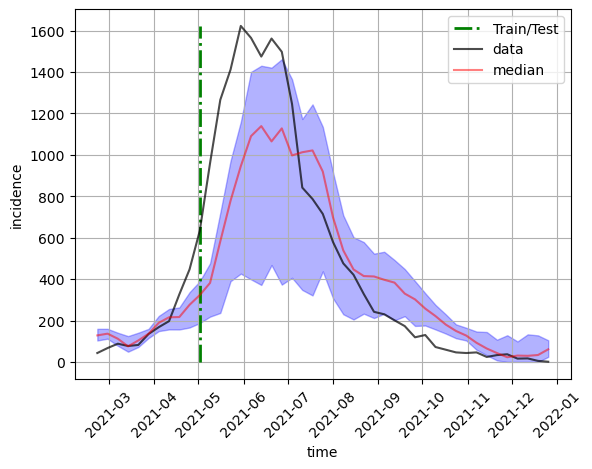

In [18]:
transf_chik_pred(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, end_train_date = END_TRAIN_CHIK,  
                            end_date = END_DATE_CHIK, filename = f'../saved_models/lstm/trained_{CITY}_model_msle_all.h5',  epochs =100, features = 11,  
                            predict_n = 4, look_back = 4, loss = 'msle', validation_split = 0.0,
                            label = f'transf_chik')

To apply the transfer learning technique we use as train data the chik data up to '2021-05-01'. We can see that after this day the model has good performance considering the next month (data between '2021-05-01' and '2021-06-01'). 

To evaluate the improvement in the performance of the model we compute the following skill score: 

$$ SS = 1 - \cfrac{RMSE_{forecast}}{RMSE_{reference}}$$ 

In the formula, the reference represent the error of the model used as reference and the forecast represent the new model that we want to compare the performance. If the SS value is above 0 or new model is better than the reference model, otherwise it's worst.

In [19]:
def ss(forecast, reference, target):
    
    rmse_f = mse(target, forecast, squared = False )
    
    rmse_r = mse(target, reference, squared = False)
    
    return 1 - (rmse_f/rmse_r)

In [20]:
with open(f'../predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'../predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

with open(f'predictions/lstm/tl_{CITY}_transf_chik.pkl', 'rb') as f:
        data_tl = pickle.load(f) 
        

plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_tl['indice'][7:],data_tl['pred'].iloc[:,-1] * data_tl['factor'], label = 'TL')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'predictions/lstm/tl_2611606_transf_chik.pkl'

In [ ]:
from datetime import datetime
ini_index = data_nn['indice'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d'))
end_index = data_nn['indice'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))

print('SS compared to NN:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_nn['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_nn['factor']))
print('SS compared to ML:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_ml['preds'][ data_ml['dates'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d')): data_ml['dates'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))] ))


### Retrain the dengue model with a custom loss function 

To specialize our lstm dengue model to predict better the peak of cases we propose a custom loss function. This function gives a weight of 10 to the predictions of ascending cases in the train data. 

This weight is given to the observations in the training data, where the fourth value is bigger than the second value of the target data. (Remember it is an array of length four since we forecast the next 4 observations).  

```
def custom_loss_msle(p = 1):
    """
    :param p: 
    """
    
    def my_loss_msle(y_true, y_pred):
        """
        :param y_true:
        :param y_pred: 
        """

        def f1(): 
            
            loss = tf.math.log(tf.math.add(y_true, 1)/ tf.math.add(y_pred, 1))
    
            loss = tf.square(loss)
        
            return tf.multiply(loss, p) 
        
        def f2(): 
            
            loss = tf.math.log(tf.math.add(y_true, 1)/ tf.math.add(y_pred, 1))
    
            loss = tf.square(loss)
        
            return loss

        msle = tf.cond(tf.less(tf.gather(y_true, 0)[1],tf.gather(y_true, 0)[3]) , 
                                     true_fn = f1,
                                     false_fn = f2 )

        return tf.reduce_mean(msle) 
    
    return my_loss_msle 
```



In [ ]:
from lstm import custom_loss_msle

In [ ]:
%%time
model = build_model(hidden = 8, features = 11, predict_n = PREDICT_N, look_back = LOOK_BACK, batch_size=1, loss = custom_loss_msle(p=10))

make_pred(model, CITY, doenca = 'dengue', epochs = 100, end_train_date = None, 
                ratio= 1.0, end_date = END_DATE, hidden = 8,
                 predict_n = PREDICT_N, look_back =  LOOK_BACK,
                  label = 'custom_msle')

See the behaviour of this model when applied in the chik data:

In [ ]:
%%time
metrics = apply_dengue_chik(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, 
                     end_date = END_DATE_CHIK, look_back = LOOK_BACK,
                     predict_n = PREDICT_N,  label_m = f'custom_msle' )

In [ ]:
with open(f'../predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'../predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)
        
plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [ ]:
print('NN error (RMSE):', mse(data_nn['target'][:, -1] * data_nn['factor'], data_nn['pred'].iloc[:,-1] * data_nn['factor'],  squared = False ))
print('ML error (RMSE):', mse(data_ml['target'][4:], data_ml['preds'], squared = False))

Apply the transfer learning technique using this new trained model:

In [ ]:
%%time
transf_chik_pred(CITY_NAME, CITY, ini_date = INI_DATE_CHIK, end_train_date = END_TRAIN_CHIK,  
                            end_date = END_DATE_CHIK, filename = f'../saved_models/lstm/trained_{CITY}_model_custom_msle.h5',  epochs =100, features = 11,  
                            predict_n = PREDICT_N, look_back = LOOK_BACK, loss = custom_loss_msle(p=10), validation_split = 0.0,
                            label = f'transf_chik')

Comparing the predictions of the NN (neural network), the TL (transfer learning) and the ML (machine learning) model:

In [ ]:
with open(f'../predictions/lstm/lstm_{CITY}_dengue_model_chik_predictions.pkl', 'rb') as f:
        data_nn = pickle.load(f)

doenca = 'dengue'
with open(f'../predictions/pgbm/pgbm_{CITY}_chik_cross_predictions.pkl', 'rb') as f:
        data_ml = pickle.load(f)

with open(f'../predictions/lstm/tl_{CITY}_transf_chik.pkl', 'rb') as f:
        data_tl = pickle.load(f) 
        

plt.figure()

plt.plot(data_nn['indice'][7:], data_nn['target'][:, -1] * data_nn['factor'] , color = 'black', label = 'data')

plt.plot(data_nn['indice'][7:],data_nn['pred'].iloc[:,-1] * data_nn['factor'], label = 'NN')

plt.plot(data_tl['indice'][7:],data_tl['pred'].iloc[:,-1] * data_tl['factor'], label = 'TL')

plt.plot(data_ml['dates'], data_ml['preds'], label = 'ML')

plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
from datetime import datetime
ini_index = data_nn['indice'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d'))
end_index = data_nn['indice'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))

print('SS compared to NN:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_nn['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_nn['factor']))
print('SS compared to ML:', ss( target = data_tl['target'][ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              forecast = data_tl['pred'].iloc[ini_index - 7: end_index - 7, -1] * data_tl['factor'],
                              reference = data_ml['preds'][ data_ml['dates'].index(datetime.strptime(INI_EVALUATE, '%Y-%m-%d')): data_ml['dates'].index(datetime.strptime(END_EVALUATE, '%Y-%m-%d'))] ))
